# Generate mock data for a cluster ensemble
## Generate cluster ensemble with random masses and redshifts

In [10]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock

clmm.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.12.0'

In [11]:
np.random.seed(11)

In [12]:
cosmo = Cosmology(H0=71.0, Omega_dm0=0.265 - 0.0448, Omega_b0=0.0448, Omega_k0=0.0)

## Generating a cluster catalog and associated source catalogs
Below, we randomly generate the masses, redshifts, concentrations and coordinates of an ensemble of `n_clusters` clusters. For simplicity, the drawing is performed uniformly in logm and redshift (instead of following a halo mass function).


In [13]:
# redshift and mass range of the galaxy clusters
z_bin = [0.2, 0.25]
logm_bin = np.array([14, 14.1])  # Solar Mass

# number of clusters in the ensemble
n_clusters = 30

# random draw in the mass and redshift range (for simplicity, uniform instead of following an actual mass function)
cluster_m = 10 ** (
    (logm_bin[1] - logm_bin[0]) * np.random.random(n_clusters) + logm_bin[0]
)  # in M_sun
cluster_z = (z_bin[1] - z_bin[0]) * np.random.random(n_clusters) + z_bin[0]

# random normal draw of cluster concentration, around c_mean
c_mean = 4.0
lnc = abs(np.log(c_mean) + 0.01 * np.random.randn(n_clusters))
concentration = np.exp(lnc)

# randomly draw cluster positions on the sky
ra = np.random.random(n_clusters) * 360  # from 0 to 360 deg
sindec = np.random.random(n_clusters) * 2 - 1
dec = np.arcsin(sindec) * 180 / np.pi  # from -90 to 90 deg

### Background galaxy catalog generation

For each cluster of the ensemble, we use `mock_data` to generate a background galaxy catalog and store the results in a `GalaxyCluster` object. Note that:
- The cluster density profiles follow the NFW parametrisation;
- The source redshifts follow the Chang et al. distribution and have associated pdfs;
- The shapes include shape noise and shape measurement errors;
- Background galaxy catalogs are independent, even if the clusters are close (i.e., no common galaxy between two catalogs).
- For each cluster we then compute
    - the tangential and cross $\Delta\Sigma$ for each background galaxy
    - the weights `w_ls` to be used to compute the corresponding radial profiles (see `demo_compute_deltasigma_weights.ipynb` notebook for details)

The cluster objects are then stored in `gclist`.

In [14]:
import warnings

warnings.simplefilter(
    "ignore"
)  # just to prevent warning print out when looping over the cluster ensemble below

In [15]:
gclist = []
# number of galaxies in each cluster field (alternatively, can use the galaxy density instead)
n_gals = 10000
# ngal_density = 10

for i in range(n_clusters):
    # generate background galaxy catalog for cluster i
    noisy_data_z = mock.generate_galaxy_catalog(
        cluster_m[i],
        cluster_z[i],
        concentration[i],
        cosmo,
        cluster_ra=ra[i],
        cluster_dec=dec[i],
        zsrc="chang13",
        delta_so=200,
        massdef="critical",
        halo_profile_model="nfw",
        zsrc_min=cluster_z[i] + 0.1,
        zsrc_max=3.0,
        field_size=10.0,
        shapenoise=0.04,
        photoz_sigma_unscaled=0.02,
        ngals=n_gals,
        mean_e_err=0.1,
    )

    cl = clmm.GalaxyCluster("mock_cluster", ra[i], dec[i], cluster_z[i], noisy_data_z)

    # compute DeltaSigma for each background galaxy
    cl.compute_tangential_and_cross_components(
        shape_component1="e1",
        shape_component2="e2",
        tan_component="DS_t",
        cross_component="DS_x",
        cosmo=cosmo,
        is_deltasigma=True,
        use_pdz=True,
    )

    # compute the weights to be used to bluid the DeltaSigma radial profiles
    cl.compute_galaxy_weights(
        use_pdz=True,
        use_shape_noise=True,
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        weight_name="w_ls",
        cosmo=cosmo,
        is_deltasigma=True,
        add=True,
    )

    # append the cluster in the list
    gclist.append(cl)

In [16]:
cl.galcat.columns

<TableColumns names=('ra','dec','e1','e2','e_err','z','ztrue','pzpdf','id','sigma_c_eff','theta','DS_t','DS_x','w_ls')>

In [17]:
noisy_data_z

ra,dec,e1,e2,e_err,z,ztrue,pzpdf,id,sigma_c_eff,theta,DS_t,DS_x,w_ls
float64,float64,float64,float64,float64,float64,float64,float64[101],int64,float64,float64,float64,float64,float64
332.5732957262586,68.6965614025538,0.1438833439102278,0.15183545496034645,0.0936320927400146,1.0188595224463335,1.0161258395411366,2.2680004720232025e-138 .. 0.0,0,3029586083090614.5,0.0031573666374007728,-561220173727074.0,-294356082587167.56,2.6712095268243273e-30
331.62593494767515,68.51170396272332,0.023673261668611244,-0.06380253115065768,0.09088472111159826,1.289183825760255,1.3038440437365568,8.90394212586036e-170 .. 0.0,1,2851555124054899.0,0.004746886497257255,-159839165674374.44,-110042331976903.78,3.09202454637612e-30
332.0635230107804,68.41797001726482,0.05831075029406791,-0.17711056410855486,0.10009906332987306,0.7491112816192751,0.7200308558025833,1.2400529403823127e-102 .. 0.0,2,3330712666319014.5,0.005393486955219521,167964658641586.6,-597908911164579.8,2.082128085520986e-30
331.2990073358691,68.46373197686921,0.12219141753647336,-0.02589674978184325,0.09199794547950552,0.5861745130373542,0.533885885461874,6.829221866893646e-79 .. 0.0,3,3766175694684391.0,0.006780726371070797,-140756404896276.66,-448864016944676.06,1.754615089879265e-30
331.7629536914463,68.84000707014403,0.050261693075473124,-0.026644036271739384,0.09109037180555139,1.650234584395911,1.6281787141754172,7.073052191483662e-214 .. 0.0,4,2724847861336652.5,0.002821124757687439,70421480850473.3,138088783743462.44,3.379912527978561e-30
332.9905468112071,68.87829438541495,0.08594603416124522,0.1996191301718456,0.10541517525676686,1.1027818662384368,1.1601345445386788,3.0192098080808473e-141 .. 0.0,5,2962828137224881.5,0.006312504032200846,292687358716658.94,-573563655906232.2,2.5048660581527877e-30
331.593999599909,68.85284411117976,-0.01561736617322667,-0.07314232163528099,0.09523095787997145,0.9535317629010183,0.9413540892420099,1.1137986528193134e-130 .. 0.0,6,3104186763826127.5,0.0037853356616689483,230670145277251.06,26306899298097.344,2.507237433953523e-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332.0239081738227,69.06838392455988,0.13435258475969244,-0.12246183969370159,0.0994320681842202,0.8035628920931495,0.7468539292432289,1.5270375724358987e-114 .. 0.0,9993,3317640872983877.0,0.005970877280516081,491718703556684.06,-349225142261207.4,2.111550086615785e-30


## Creating ClusterEnsemble object and estimation of individual excess surface density profiles
From the galaxy cluster object list `gclist`, we instantiate a cluster ensemble object `clusterensemble`. This instantiation step uses
 - the individual galaxy input $\Delta\Sigma_+$ and $\Delta\Sigma_{\times}$ values (computed in the previous step, `DS_{t,x}`)
 - the corresponding individual input weights `w_ls` (computed in the previous step)

to compute

- the output tangential `DS_t` and cross signal `DS_x` binned profiles (where the binning is controlled by `bins`)
- the associated profile weights `W_l` (that will be used to compute the stacked profile)


In [18]:
ensemble_id = 1
names = ["id", "ra", "dec", "z", "radius", "gt", "gx", "W_l"]
bins = np.logspace(np.log10(0.3), np.log10(5), 10)
clusterensemble = ClusterEnsemble(
    ensemble_id,
    gclist,
    tan_component_in="DS_t",
    cross_component_in="DS_x",
    tan_component_out="DS_t",
    cross_component_out="DS_x",
    weights_in="w_ls",
    weights_out="W_l",
    bins=bins,
    bin_units="Mpc",
    cosmo=cosmo,
)

There is also the option to create an `ClusterEnsemble` object without the clusters list. Then, the user may compute the individual profile for each wanted cluster and compute the radial profile once all the indvidual profiles have been computed. This method may be reccomended if there a large number of clusters to avoid excess of memory allocation, since the user can generate each cluster separately, compute its individual profile and then delete the cluster object. 

In [19]:
ensemble_id2 = 2
empty_cluster_ensemble = ClusterEnsemble(ensemble_id2)
for cluster in gclist:
    empty_cluster_ensemble.make_individual_radial_profile(
        galaxycluster=cluster,
        tan_component_in="DS_t",
        cross_component_in="DS_x",
        tan_component_out="DS_t",
        cross_component_out="DS_x",
        weights_in="w_ls",
        weights_out="W_l",
        bins=bins,
        bin_units="Mpc",
        cosmo=cosmo,
    )

A third option is where all clusters already have the profile computed, and we just add those to the `ClusterEnsemble` object:

In [20]:
# add profiles to gclist
for cluster in gclist:
    cluster.make_radial_profile(
        tan_component_in="DS_t",
        cross_component_in="DS_x",
        tan_component_out="DS_t",
        cross_component_out="DS_x",
        weights_in="w_ls",
        weights_out="W_l",
        bins=bins,
        bin_units="Mpc",
        cosmo=cosmo,
        use_weights=True,
    )

In [21]:
cluster.profile

radius_min,radius,radius_max,DS_t,DS_t_err,DS_x,DS_x_err,z,z_err,n_src,W_l
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0.29999999999999993,0.35538888084857756,0.4100928778589602,47114109394749.69,74981653954779.48,71725831060897.5,70821817988056.39,1.2294188552708236,0.12542225116544745,29,6.36216161623601e-29
0.4100928778589602,0.49712754212399335,0.5605872282354804,28407616591790.055,42764109085226.55,-57071960817480.51,46736076941033.766,1.3771445318850362,0.0970295261874978,49,1.15161521880834e-28
0.5605872282354804,0.6712361227940042,0.7663094323935532,74964576073879.81,38525941380753.984,56308907913143.11,42228781968988.305,1.4005388323178487,0.06709616391264091,86,2.113338478541802e-28
0.7663094323935532,0.9063818034287947,1.0475268015357952,31222548973788.72,28953248329270.5,4403827566746.238,30962934549206.992,1.3571852747152193,0.05479486143577199,158,3.6399138841685154e-28
1.0475268015357952,1.2573762610803199,1.4319442689206874,43299578835110.22,21990385325329.086,150722770699.5796,20759010434230.367,1.345164104104211,0.034977356940368715,296,7.038287482539167e-28
1.4319442689206874,1.7043857764046781,1.9574338205844326,9749022992701.127,15940514809587.162,-8821468381836.344,15585239988553.42,1.3306378739615508,0.026819503616418047,535,1.270287908236562e-27
1.9574338205844326,2.3390498533169923,2.6757655623397656,26294486206933.766,10815129177769.535,-29746134079555.707,10982086708853.01,1.3595192146604758,0.01957031696068926,1051,2.5211882937411874e-27
2.6757655623397656,3.1943994280425922,3.6577079997860453,4645975281894.315,7782221363303.09,-6755554338437.125,7744746597065.155,1.3679035365281023,0.014534053109116159,1951,4.719527212638533e-27
3.6577079997860453,4.368455348815572,5.0,3195312396468.185,5740366240659.976,-1692230857239.6074,5890154465299.26,1.3496089726931955,0.010516912111932246,3644,8.730103338179243e-27


In [22]:
ensemble_id3 = 3
empty_cluster_ensemble = ClusterEnsemble(ensemble_id3)
for cluster in gclist:
    empty_cluster_ensemble.add_individual_radial_profile(
        galaxycluster=cluster,
        profile_table=cluster.profile,
        tan_component="DS_t",
        cross_component="DS_x",
        weights="W_l",
    )

## Stacked profile of the cluster ensemble
The stacked radial profile of the ensemble is then obtained as 

In [23]:
clusterensemble.make_stacked_radial_profile(tan_component="DS_t", cross_component="DS_x")

## Covariance (Bootstrap, sample, Jackknife) of the stack between radial bins
Radial bins may be correlated and the `ClusterEnsemble` class provides three methods to compute the covariance matrix of the stacked signal, from the data:
- The Sample covariance directly computes the covariance between radial bins of the `N` individual cluster profiles of the stack.
- The Bootstrap approach is a resampling technique generating `n_bootstrap` ensembles of `N` randomly drawn clusters from the original ensemble, allowing for duplication. For each new ensemble, the stacked profile is computed and the covariance computed over the `n_bootstrap` stacks.
- The Jackknife approach is another resampling technique, that divides the sky in a given number of regions $N_{\rm region}$ and computes the covariance removing one region (i.e the clusters of the ensemble in that region) at a time. The stack is then computed using the remaining clusters and the covariance computed over the $N_{\rm region}$ number of stacks. The division of the sky is done using the Healpix pixelisation scheme and is controlled by the `n_side` parameter, with $N_{\rm region}=12 N_{\rm side}^2$.

NB: Approaches exist to compute the theoretical covariance of a stack but these are not (yet) available in `CLMM`

In [24]:
clusterensemble.compute_sample_covariance(tan_component="DS_t", cross_component="DS_x")
clusterensemble.compute_bootstrap_covariance(
    tan_component="DS_t", cross_component="DS_x", n_bootstrap=300
)
clusterensemble.compute_jackknife_covariance(
    n_side=16, tan_component="DS_t", cross_component="DS_x"
)

[]

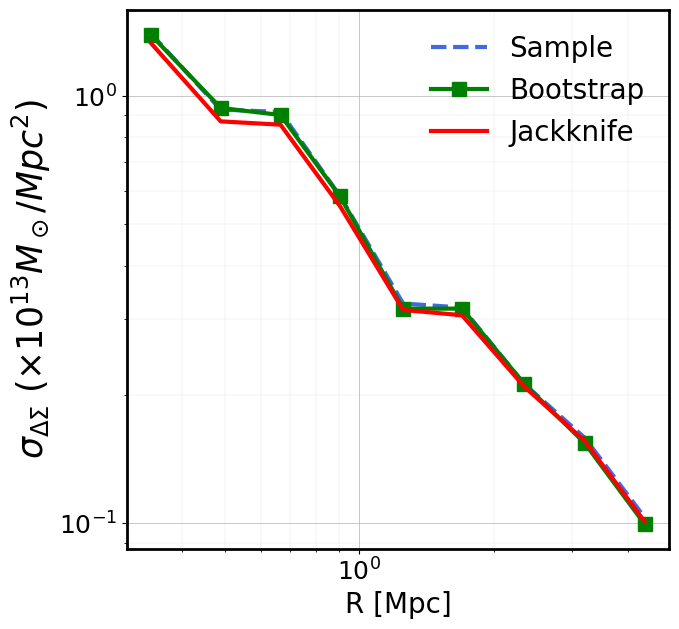

In [25]:
plt.figure(figsize=(7, 7))
plt.rcParams["axes.linewidth"] = 2
plt.plot(
    clusterensemble.data["radius"][0],
    clusterensemble.cov["tan_sc"].diagonal() ** 0.5 / 1e13,
    "--",
    c="royalblue",
    label="Sample",
    linewidth=3,
)
plt.plot(
    clusterensemble.data["radius"][0],
    clusterensemble.cov["tan_bs"].diagonal() ** 0.5 / 1e13,
    "-s",
    c="g",
    label="Bootstrap",
    linewidth=3,
    markersize=10,
)
plt.plot(
    clusterensemble.data["radius"][0],
    clusterensemble.cov["tan_jk"].diagonal() ** 0.5 / 1e13,
    c="r",
    label="Jackknife",
    linewidth=3,
)
plt.xlabel("R [Mpc]", fontsize=20)
plt.ylabel(r"$\sigma_{\Delta\Sigma}\ (\times 10^{13} M_\odot /Mpc^2)$", fontsize=25)
plt.tick_params(axis="both", which="major", labelsize=18)
plt.legend(frameon=False, fontsize=20)
plt.minorticks_on()
plt.grid(lw=0.5)
plt.grid(which="minor", lw=0.1)
plt.loglog()

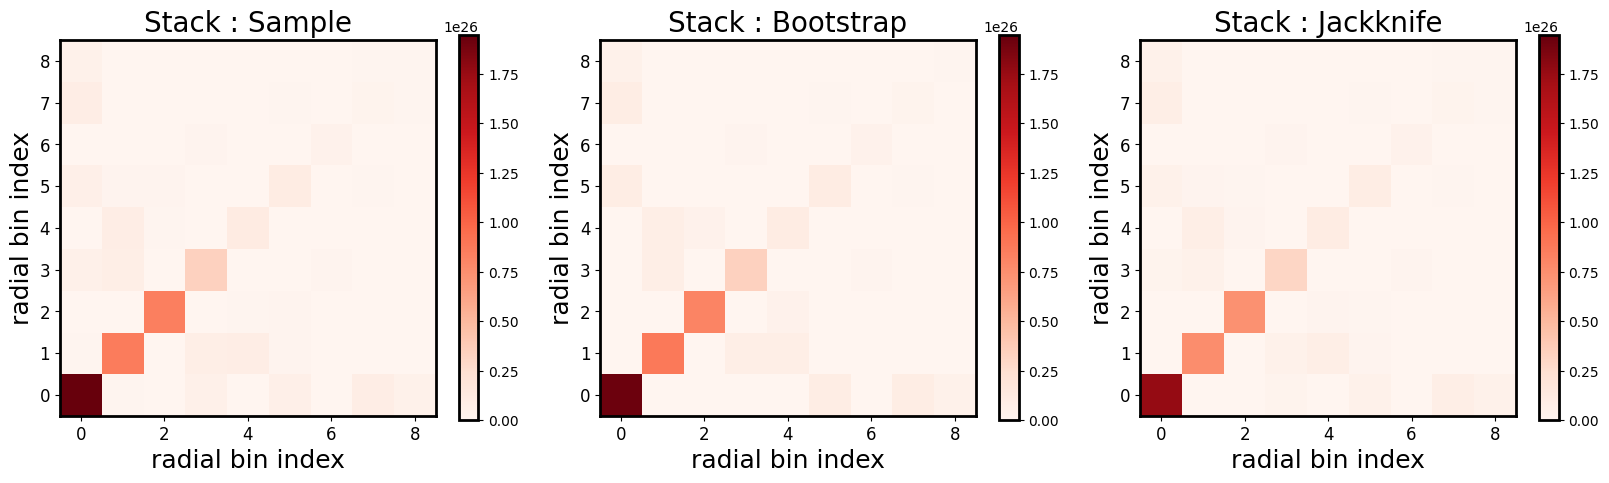

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.rcParams["axes.linewidth"] = 2
fig.subplots_adjust(wspace=0.15, hspace=0)

maximum = clusterensemble.cov["tan_sc"].max()
for ax, cov, label in zip(
    axes,
    [clusterensemble.cov["tan_sc"], clusterensemble.cov["tan_bs"], clusterensemble.cov["tan_jk"]],
    ["Stack : Sample", "Stack : Bootstrap", "Stack : Jackknife"],
):
    ax.set_title(label, fontsize=20)
    ax.set_xlabel("radial bin index", fontsize=18)
    ax.set_ylabel("radial bin index", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=12)
    im = ax.imshow(cov, cmap="Reds", vmin=0, vmax=maximum, origin="lower")
    plt.colorbar(im, ax=ax)

## Visualizing the stacked profiles and corresponding model

In the figure below, we plot:
- the individual $\Delta\Sigma$ profiles of the clusters (light blue)
- the stacked signal (red symbols)
- the prediction computed using a NFW profile and the mean values of the mass, concentration and redshift in the stack (dashed black)

In [27]:
moo = clmm.Modeling(massdef="critical", delta_mdef=200, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
# Average values of mass and concentration of the ensemble to be used below to overplot the model on the stacked profile
moo.set_concentration(concentration.mean())
moo.set_mass(cluster_m.mean())

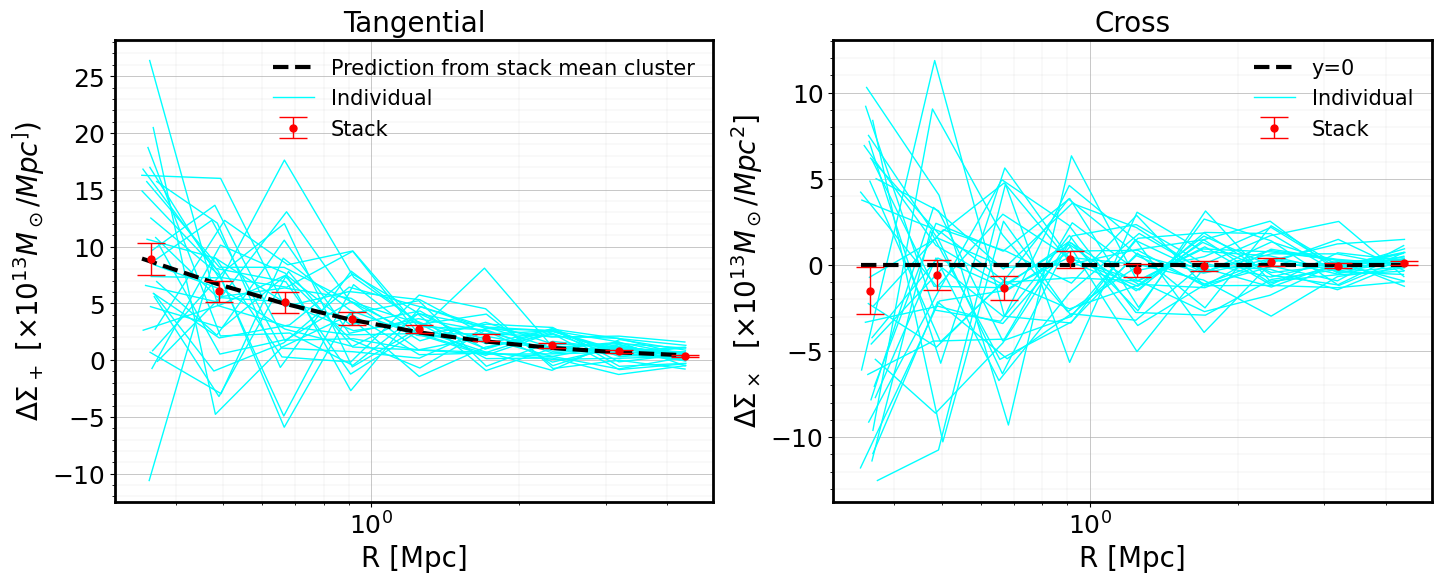

In [28]:
r_stack, gt_stack, gx_stack = (clusterensemble.stacked_data[c] for c in ("radius", "DS_t", "DS_x"))
plt.rcParams["axes.linewidth"] = 2
fig, axs = plt.subplots(1, 2, figsize=(17, 6))

err_gt = clusterensemble.cov["tan_sc"].diagonal() ** 0.5 / 1e13
err_gx = clusterensemble.cov["cross_sc"].diagonal() ** 0.5 / 1e13

axs[0].errorbar(
    r_stack,
    gt_stack / 1e13,
    err_gt,
    markersize=5,
    c="r",
    fmt="o",
    capsize=10,
    elinewidth=1,
    zorder=1000,
    alpha=1,
    label="Stack",
)
axs[1].errorbar(
    r_stack,
    gx_stack / 1e13,
    err_gx,
    markersize=5,
    c="r",
    fmt="o",
    capsize=10,
    elinewidth=1,
    zorder=1000,
    alpha=1,
    label="Stack",
)

axs[0].plot(
    clusterensemble.data["radius"][0],
    moo.eval_excess_surface_density(clusterensemble.data["radius"][0], cluster_z.mean()) / 1e13,
    "--k",
    linewidth=3,
    label="Prediction from stack mean cluster",
    zorder=100,
)
axs[1].plot(
    clusterensemble.data["radius"][0],
    0 * moo.eval_excess_surface_density(clusterensemble.data["radius"][0], cluster_z.mean()) / 1e13,
    "--k",
    linewidth=3,
    label="y=0",
    zorder=100,
)

axs[0].set_xscale("log")
axs[1].set_xscale("log")


for i in range(n_clusters):
    axs[0].plot(
        clusterensemble.data["radius"][i],
        clusterensemble.data["DS_t"][i] / 1e13,
        "cyan",
        label="Individual",
        alpha=1,
        linewidth=1,
    )
    axs[1].plot(
        clusterensemble.data["radius"][i],
        clusterensemble.data["DS_x"][i] / 1e13,
        "cyan",
        label="Individual",
        alpha=1,
        linewidth=1,
    )
    if i == 0:
        axs[0].legend(frameon=False, fontsize=15)
        axs[1].legend(frameon=False, fontsize=15)
# axs[0].plot(np.average(clusterensemble.data['radius'], axis = 0), np.average(clusterensemble.data['gt'], weights = None, axis = 0)/1e13)
axs[0].set_xlabel("R [Mpc]", fontsize=20)
axs[1].set_xlabel("R [Mpc]", fontsize=20)
axs[0].tick_params(axis="both", which="major", labelsize=18)
axs[1].tick_params(axis="both", which="major", labelsize=18)
axs[0].set_ylabel(r"$\Delta\Sigma_+$ $[\times 10^{13} M_\odot /Mpc^])$", fontsize=20)
axs[1].set_ylabel(r"$\Delta\Sigma_\times$  $[\times 10^{13} M_\odot /Mpc^2]$", fontsize=20)
axs[0].set_title(r"Tangential", fontsize=20)
axs[1].set_title(r"Cross", fontsize=20)

for ax in axs:
    ax.minorticks_on()
    ax.grid(lw=0.5)
    ax.grid(which="minor", lw=0.1)

plt.show()

## Saving/Loading ClusterEnsemble
The `ClusterEnsemble` object also have an option for saving/loading:

In [29]:
clusterensemble.save("ce.pkl")

In [30]:
clusterensemble2 = ClusterEnsemble.load("ce.pkl")